#### <b>필요한 라이브러리 불러오기</b>

In [1]:
!git clone https://github.com/ndb796/Small-ImageNet-Validation-Dataset-1000-Classes
%cd Small-ImageNet-Validation-Dataset-1000-Classes

Cloning into 'Small-ImageNet-Validation-Dataset-1000-Classes'...
remote: Enumerating objects: 6016, done.
remote: Total 6016 (delta 0), reused 0 (delta 0), pack-reused 6016
Receiving objects: 100% (6016/6016), 624.07 MiB | 34.01 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (5004/5004), done.
/content/Small-ImageNet-Validation-Dataset-1000-Classes


In [2]:
# 필요한 PyTorch 라이브러리 불러오기
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [3]:
# GPU 장치 사용 설정
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

#### <b>이미지넷(ImageNet)에 정의된 클래스 정보 가져오기</b>

In [4]:
from urllib.request import urlretrieve
import json

# 이미지넷(ImageNet)에 정의된 1,000개의 레이블(클래스) 정보 가져오기
with open('./imagenet.json') as f:
    imagenet_labels = json.load(f)

In [5]:
# 인덱스(index) 18에 해당하는 클래스는 까치(magpie)입니다.
print(imagenet_labels[18])

magpie


#### <b>이미지 시각화(Visualization) 해보기</b>

In [6]:
imsize = 299

preprocess = transforms.Compose([
    transforms.Resize((imsize, imsize)), # 이미지의 크기를 변경
    transforms.ToTensor(), # torch.Tensor 형식으로 변경 [0, 255] → [0, 1]
])

In [7]:
# 이미지(그림) 출력 관련 라이브러리
import matplotlib.pyplot as plt
import PIL

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

In [8]:
# 특정한 경로에서 이미지를 가져와 torch.Tensor로 변환하는 함수
def image_loader(path):
    image = PIL.Image.open(path)
    # 전처리 이후에 네트워크 입력에 들어갈 이미지에 배치 목적의 차원(dimension) 추가
    image = preprocess(image).unsqueeze(0)
    return image.to(device, torch.float) # GPU로 올리기

In [9]:
image = image_loader('./ILSVRC2012_img_val_subset/18/ILSVRC2012_val_00000476.JPEG')

In [10]:
# torch.Tensor 형태의 이미지를 화면에 출력하는 함수
def imshow(tensor):
    # matplotlib는 CPU 기반이므로 CPU로 옮기기
    image = tensor.cpu().clone()
    # torch.Tensor에서 사용되는 배치 목적의 차원(dimension) 제거
    image = image.squeeze(0)
    # PIL 객체로 변경 
    image = transforms.ToPILImage()(image)
    # 이미지를 화면에 출력(matplotlib는 [0, 1] 사이의 값이라고 해도 정상적으로 처리)
    plt.imshow(image)
    plt.show()

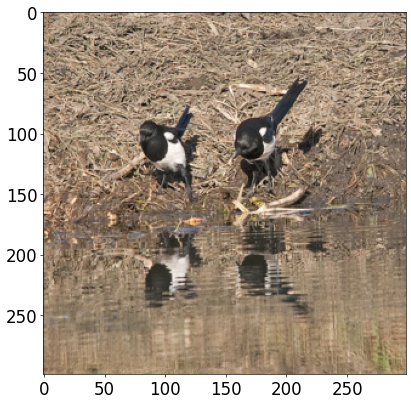

In [11]:
imshow(image)

#### <b>사전 학습된(pretrained) 모델을 불러와 사용해보기</b>

In [12]:
# 입력 데이터 정규화를 위한 클래스 정의
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [13]:
# 공격자가 가지고 있는 torch.Tensor 형식의 이미지 데이터는 입력 정규화를 거치기 전이므로, 정규화 이후에 모델에 넣도록 설정
model = nn.Sequential(
    # 기본적인 Inception v3와 동일한 동작을 위하여 정규화 레이어 추가
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torch.hub.load('pytorch/vision:v0.6.0', 'resnet152', pretrained=True)
).to(device).eval() # 모델을 GPU로 옮기기 및 평가(테스트) 모드로 변경

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [14]:
# 기본적인 이미지를 실제 모델에 넣어 결과 확인
outputs = model(image)
# 확률을 계산하기 위해 소프트맥스(softmax) 함수 취하기
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
# 가장 높은 값을 가지는 5개의 인덱스를 하나씩 확인하며
print("< 가장 높은 확률을 가지는 클래스들 >")
for i in outputs[0].topk(5)[1]:
    # 높은 값을 가지는 순서대로 인덱스에 해당하는 클래스 이름과, 그 확률 값 출력하기
    print(f"인덱스: {i.item()} / 클래스명: {imagenet_labels[i]} / 확률: {round(percentages[i].item(), 4)}%")

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 66.0116%
인덱스: 143 / 클래스명: oystercatcher, oyster catcher / 확률: 6.6801%
인덱스: 137 / 클래스명: American coot, marsh hen, mud hen, water hen, Fulica americana / 확률: 4.7399%
인덱스: 136 / 클래스명: European gallinule, Porphyrio porphyrio / 확률: 2.1057%
인덱스: 20 / 클래스명: water ouzel, dipper / 확률: 1.1307%


#### <b>Load Full Validation Dataset</b>

In [16]:
import os
from torchvision import datasets

data_dir = './ILSVRC2012_img_val_subset'

val_datasets = datasets.ImageFolder(os.path.join(data_dir), preprocess)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=16, shuffle=True, num_workers=4)
print('Validation dataset size:', len(val_datasets))

class_names = val_datasets.classes
print('The number of classes:', len(class_names))

Validation dataset size: 5000
The number of classes: 1000


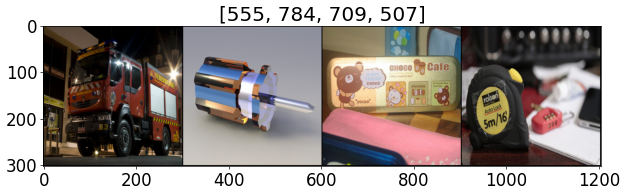

Image #1: fire engine, fire truck
Image #2: screwdriver
Image #3: pencil box, pencil case
Image #4: combination lock


In [19]:
import torchvision
import numpy as np


def imshow_batch(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of validation image
iterator = iter(val_dataloader)

# visualize a batch of validation image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow_batch(out, title=[int(class_names[x]) for x in classes[:4]])

for i, x in enumerate(classes[:4]):
    imagenet_index = int(class_names[x])
    label = imagenet_labels[imagenet_index]
    print(f'Image #{i + 1}: {label}')

#### <b>Validation Phase</b>

[Prediction Result Examples]


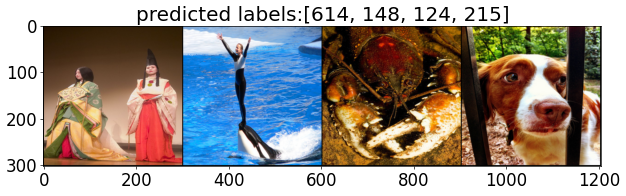

Real labels >>>>>>>>>>>>>>>
Image #1: kimono (614)
Image #2: killer whale, killer, orca, grampus, sea wolf, Orcinus orca (148)
Image #3: crayfish, crawfish, crawdad, crawdaddy (124)
Image #4: Brittany spaniel (215)


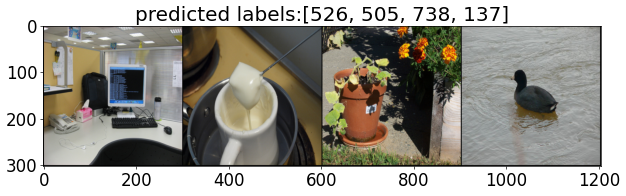

Real labels >>>>>>>>>>>>>>>
Image #5: desk (526)
Image #6: eggnog (969)
Image #7: pot, flowerpot (738)
Image #8: American coot, marsh hen, mud hen, water hen, Fulica americana (137)
[Validation] Loss: 0.9256 Acc: 78.7000% Time: 69.7443s


In [23]:
import time

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, basic_labels) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        labels = torch.zeros_like(basic_labels).to(device)
        for j in range(labels.shape[0]):
            labels[j] = int(class_names[basic_labels[j]])
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow_batch(images.cpu(), title='predicted labels:' + str([int(x) for x in preds[:4]]))
            print('Real labels >>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow_batch(images.cpu(), title='predicted labels:' + str([int(x) for x in preds[4:8]]))
            print('Real labels >>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')

    epoch_loss = running_loss / len(val_datasets)
    epoch_acc = running_corrects / len(val_datasets) * 100.
    print('[Validation] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))